In [202]:
%matplotlib inline

import os
from glob import glob
import datacleaner
reload(datacleaner)
import matplotlib.pyplot as plt
from datacleaner import LightCurve, generate_fiducial_model_lc_short
import numpy as np
import matplotlib.gridspec as gridspec

long_lc = LightCurve.from_dir('../lightcurves/raw_long')

# Chunking by stellar rotation

In [320]:
rotation_period = np.loadtxt('../params/stellar_rotation_period.txt').item()

# Move over window 1/3 of a rotation

# for rotation_overlap_interval in range(3):

#     rotations = ((long_lc.times.jd - long_lc.times.jd[0]) / rotation_period - 
#                  rotation_overlap_interval/3.)
#     fig = plt.figure(figsize=(15, 15))
#     gs = gridspec.GridSpec(7, 6)
#     axes = [plt.subplot(gs_axis) for gs_axis in gs]

#     for i in range(42):#range(len(set(rotations.astype(int)))):
#         this_rotation = (i < rotations) & (rotations < i+1)

#         transit_model = generate_fiducial_model_lc_short(long_lc.times.jd[this_rotation],
#                                                          2454605.89167, 0.00348, 0.1029, 0.295)
#         transits_in_chunk = (transit_model != 1).any()
        
#         sorted_times = np.sort(long_lc.times.jd[this_rotation])
#         dt = np.diff(sorted_times)
#         jump_inds = np.argwhere(dt > 2./24)#10*np.nanmedian(dt))
#         jump_times = sorted_times[jump_inds]

#         if len(jump_times) > 0:
#             for jump_time in jump_times:
#                 axes[i].axvline(jump_time, color='r') 

#         axes[i].plot(long_lc.times.jd[this_rotation], 
#                      long_lc.fluxes[this_rotation], 'k.')
#         axes[i].set(yticks=[], xticks=[], 
#                     title='Rotation Cut: {0}'.format(i), 
#                     axis_bgcolor='w' if transits_in_chunk else '#FF8080')
        
#     gs.tight_layout(fig, rect=[0, 0.03, 1, 0.97])
#     fig.suptitle('Rotation Offset: {0}/3'
#                  .format(rotation_overlap_interval),
#                  fontsize=16)
#     plt.show()
#     print('\n\n')

# Chunking by data gaps

72


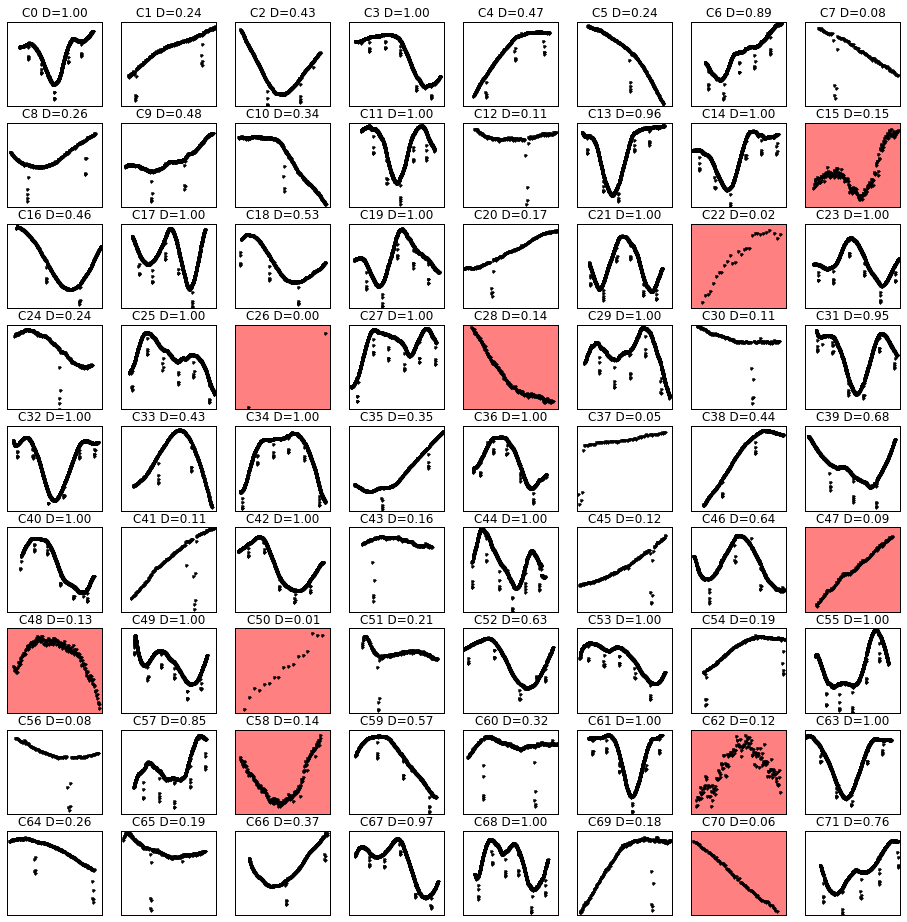

In [164]:
sorted_times = np.sort(long_lc.times.jd)
dt = np.diff(sorted_times)
jump_inds = np.argwhere(dt > 2./24)
jump_times = sorted_times[jump_inds]

chunk_masks = [(long_lc.times.jd > jump_times[i]) & 
               (long_lc.times.jd < jump_times[i+1])
               for i in range(len(jump_inds) -1)]

def break_up_into_rotations(chunk_masks, n_rotation_factor = 0.9):
    chunk_masks_limited = chunk_masks[:]
    
    n_indices_added = 0
    for j, chunk in enumerate(chunk_masks):
        t = long_lc.times.jd[chunk]
        
        if len(t) > 1 and t.max() - t.min() > n_rotation_factor*rotation_period: 
            chunk_masks_limited.pop(j+n_indices_added)

            subchunk1 = ((long_lc.times.jd >= t.min()) & 
                         (long_lc.times.jd <= t.min() + n_rotation_factor*rotation_period))
            subchunk2 = ((long_lc.times.jd >= t.min() + n_rotation_factor*rotation_period) & 
                         (long_lc.times.jd <= t.max()))

            t_subchunk2 = long_lc.times.jd[subchunk2]
            #assert t_subchunk2.max() - t_subchunk2.min() < rotation_period

            chunk_masks_limited.insert(j+n_indices_added, subchunk1)
            chunk_masks_limited.insert(j+n_indices_added+1, subchunk2)
            n_indices_added += 1
            
    return chunk_masks_limited

def break_up_into_rotations_recurse(chunk_masks, n_rotation_factor=0.9, 
                                    recursion_depth=5):
    chunk_masks_limited = break_up_into_rotations(chunk_masks, 
                                                  n_rotation_factor)
    for i in range(recursion_depth - 1):
        chunk_masks_limited = break_up_into_rotations(chunk_masks_limited, 
                                                      n_rotation_factor)
    return chunk_masks_limited

chunk_masks_limited = break_up_into_rotations_recurse(chunk_masks)

print(len(chunk_masks_limited))

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(9, 8)
axes = [plt.subplot(gs_axis) for gs_axis in gs]

#fig_wlc, ax_wlc = plt.subplots()

chunk_has_transits = []
light_curve_chunks = []

for i, chunk in enumerate(chunk_masks_limited):
    transit_model = generate_fiducial_model_lc_short(long_lc.times.jd[chunk],
                                                     2454605.89167, 0.00348, 
                                                     0.1029, 0.295)
    transits_in_chunk = (transit_model != 1).any()
    chunk_duration = long_lc.times.jd[chunk].max() - long_lc.times.jd[chunk].min()
    rotation_fraction = chunk_duration / (n_rotation_factor*rotation_period)
    chunk_has_transits.append(transits_in_chunk)
    if transits_in_chunk:
        light_curve_chunks.append(LightCurve(times=long_lc.times.jd[chunk], 
                                             fluxes=long_lc.fluxes[chunk],
                                             errors=long_lc.errors[chunk],
                                             quarters=long_lc.quarters[chunk]))    
    
    assert rotation_fraction <= 1, "Chunk {0} too long".format(i)
    
    axes[i].plot(long_lc.times.jd[chunk], 
                 long_lc.fluxes[chunk], 'k.')
    axes[i].set(yticks=[], xticks=[], 
                title='C{0} D={1:.2f}'.format(i, rotation_fraction), 
                axis_bgcolor='w' if transits_in_chunk else '#FF8080')
    
#    ax_wlc.plot(long_lc.times.jd[chunk], 
#                 long_lc.fluxes[chunk], 'k.')
plt.show()

## Identify discontinuous breaks

* Find all gaps >2 hrs
* fit linear/quadratic model to the ~50 fluxes nearest the gap on both sides
* fits with high $\chi^2$ likely discontinuous, low $\chi^2$ likely continuous - identify threshold
* consider discontinuous breaks to be natural boundaries for chopping up STSP runs

[468, 2092, 6162, 7582, 10296, 14404, 18890, 23162, 24405, 26268, 28029, 29412, 30878, 33858, 35319, 36449, 37776, 38869, 43112, 45728, 47382, 47634, 49381, 50916]
Constraints imposed: chi2 < 150 AND gap duration < 8 days


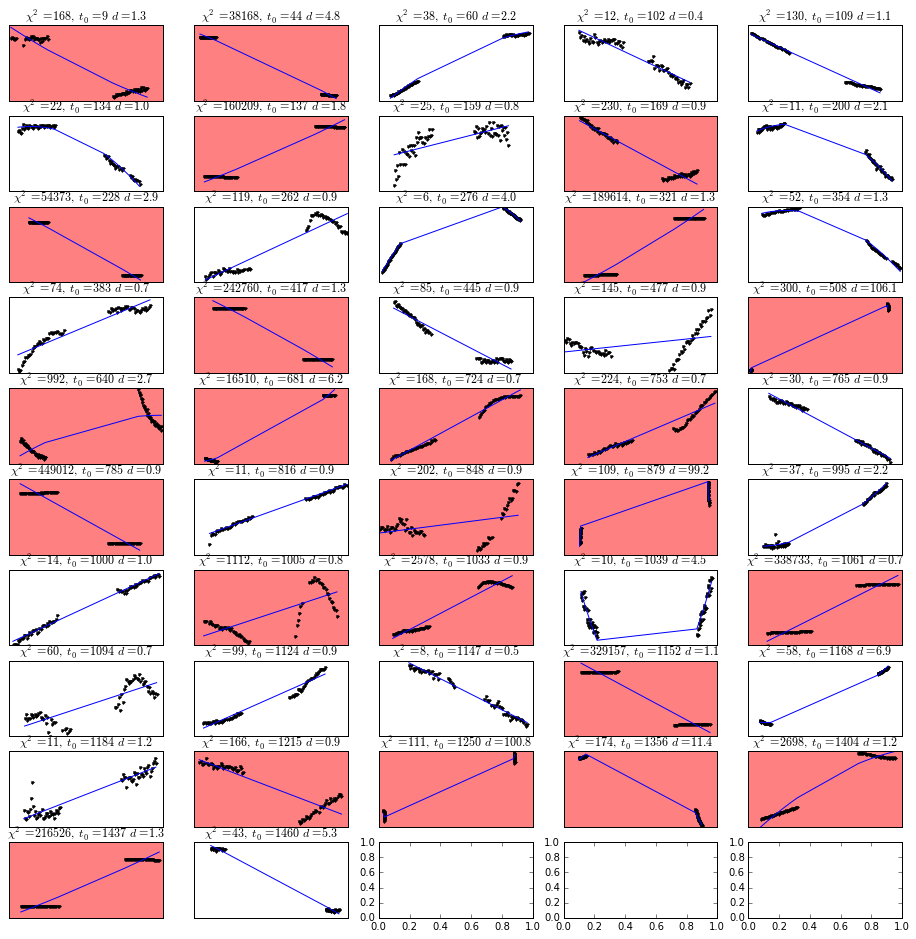

In [378]:
n_segments = 5
ignore_last = 12
sort_by_time = np.argsort(long_lc.times.jd)

dt = np.diff(long_lc.times.jd[sort_by_time])
two_hour_gaps = np.argwhere(dt > 4./24)
gap_duration = dt[two_hour_gaps].T[0]
gap_times = long_lc.times.jd[sort_by_time][two_hour_gaps].T[0]

# Now that gap times are identified, mask out transits during fits!

import warnings
warnings.simplefilter('ignore', np.RankWarning)

gap_chi2 = np.zeros_like(gap_times)
n_points_near_gap = 70
fit_order = 2
t_fits = []
f_fits = []
model_fits = []
for i, t_gap in enumerate(gap_times):
    # Identify the index before the gap
    gap_ind = np.argwhere(long_lc.times.jd[sort_by_time] == t_gap)[0]
    # Identify the n_points_near_gap nearest to gap_ind
    nearest_inds = gap_ind + np.arange(-n_points_near_gap/2, n_points_near_gap/2)
    # Mask out the transits in the time range:
    transit_model = generate_fiducial_model_lc_short(long_lc.times.jd[sort_by_time][nearest_inds],
                                                     2454605.89167, 0.00348, 
                                                     0.1029, 0.295)
    out_of_transit = np.argwhere(transit_model == 1).T[0]

    t_fits.append(long_lc.times.jd[sort_by_time][nearest_inds][out_of_transit])
    f_fits.append(long_lc.fluxes[sort_by_time][nearest_inds][out_of_transit])
    pfit = np.polyfit(t_fits[i], f_fits[i], fit_order)
    model_fits.append(np.polyval(pfit, t_fits[i]))
    gap_chi2[i] = (np.sum((model_fits[i] - f_fits[i])**2 / 
                         long_lc.errors[sort_by_time][nearest_inds][out_of_transit]**2) 
                   / len(model_fits[i]))

chi2_threshold = 150
gap_dur_threshold = 8
gap_times_significant = gap_times[(gap_chi2 > chi2_threshold) | 
                                  (gap_duration > gap_dur_threshold)]
sorted_gap_inds = [np.argwhere(long_lc.times.jd[sort_by_time] == gts)[0][0] for gts in gap_times_significant]
print(sorted_gap_inds)
####
# Split times, fluxes into groups for plotting

s_times = np.split(long_lc.times.jd[sort_by_time][:-ignore_last], 5)
s_fluxes = np.split(long_lc.fluxes[sort_by_time][:-ignore_last], 5)

#plt.hist(gap_chi2, 20, range=[0, 0.1e7]);

print("Constraints imposed: chi2 < {0} AND gap duration < {1} days"
      .format(chi2_threshold, gap_dur_threshold))

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(10, 5)
axes = [plt.subplot(gs_axis) for gs_axis in gs]

for i, t, f, m, g_chi2, g_dur in zip(range(len(gap_chi2)), t_fits, f_fits, model_fits, gap_chi2, gap_duration):
    ratio_of_chi2 = (gap_chi2[i] - np.min(gap_chi2))/np.max(gap_chi2)
    axes[i].plot(t, f, 'k.')
    axes[i].plot(t, m, 'b')
    axes[i].set(yticks=[], xticks=[], 
                title=('$\\chi^2 = {0:0.0f}, \\,t_0={1:.0f} \\,d={2:.1f}$'
                       .format(gap_chi2[i], t[0]-s_times[0][0], gap_duration[i])), 
                axis_bgcolor='w' if (g_chi2 < chi2_threshold and 
                                     g_dur < gap_dur_threshold) else '#FF8080')
                #axis_bgcolor=plt.cm.Reds(ratio_of_chi2))
plt.show()

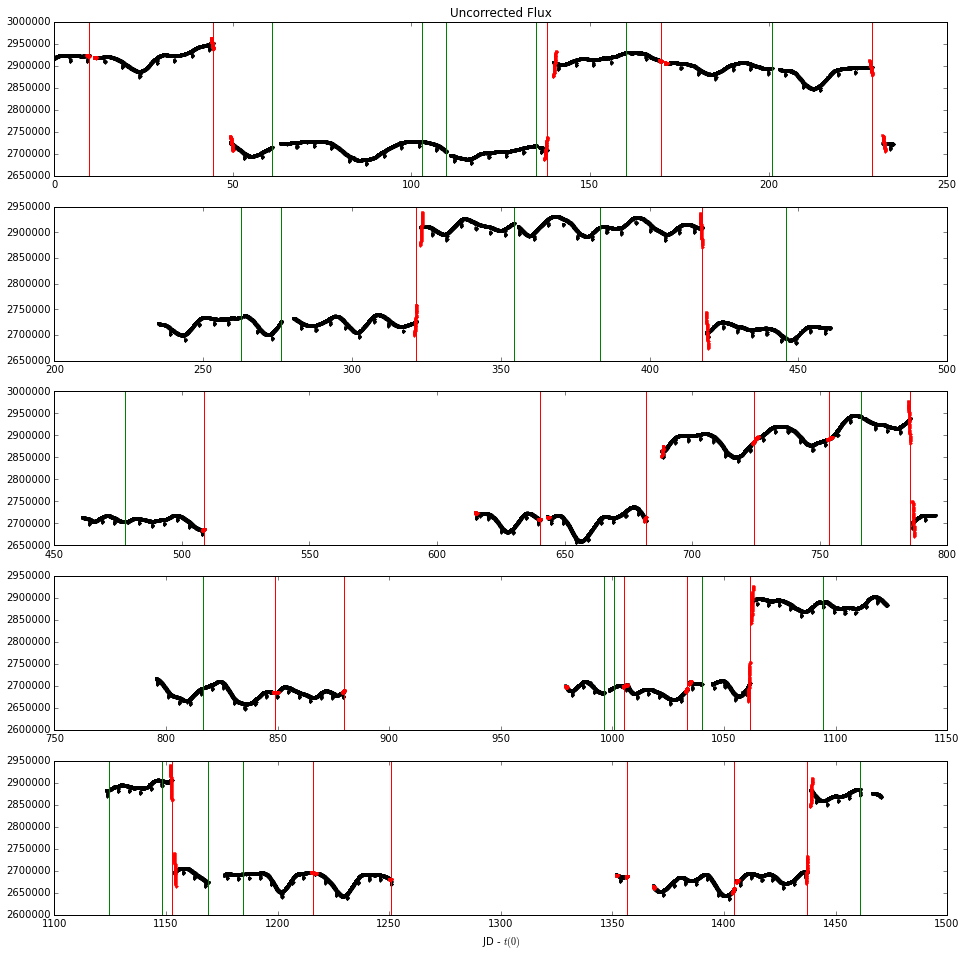

In [372]:
fig, ax = plt.subplots(n_segments, 1, figsize=(16, 16))

for i, t, f in zip(range(n_segments), s_times, s_fluxes):
    t0 = s_times[0][0]
    ax[i].plot(t - t0, f, '.', color='k')

    for t_gap, t_fit, f_fit, model_fit, g_chi2, g_dur in zip(gap_times, t_fits,f_fits, 
                                                             model_fits, gap_chi2, gap_duration):
        # Plot everything for the "discontinuous" flagged gaps
        if g_chi2 > chi2_threshold or (g_dur > gap_dur_threshold):
            if t.min() < t_fit.min() < t.max():
                #ax[i].plot(t_fit - t0, f_fit, 'r.')
                ax[i].plot(t_fit - t0, model_fit, 'r.')

            if t.min() < t_gap < t.max():
                ax[i].axvline(t_gap - t0, color='r')
                
        # plot lines in different color for "continuous" flagged gaps
        else:
            if t.min() < t_gap < t.max():
                ax[i].axvline(t_gap - t0, color='g')
ax[-1].set_xlabel('JD - $t(0)$')
ax[0].set_title('Uncorrected Flux')
plt.show()

In [373]:
print(len(gap_times), len(gap_times_significant))
#plt.hist(gap_duration, range=[0, 10]);

(47, 24)


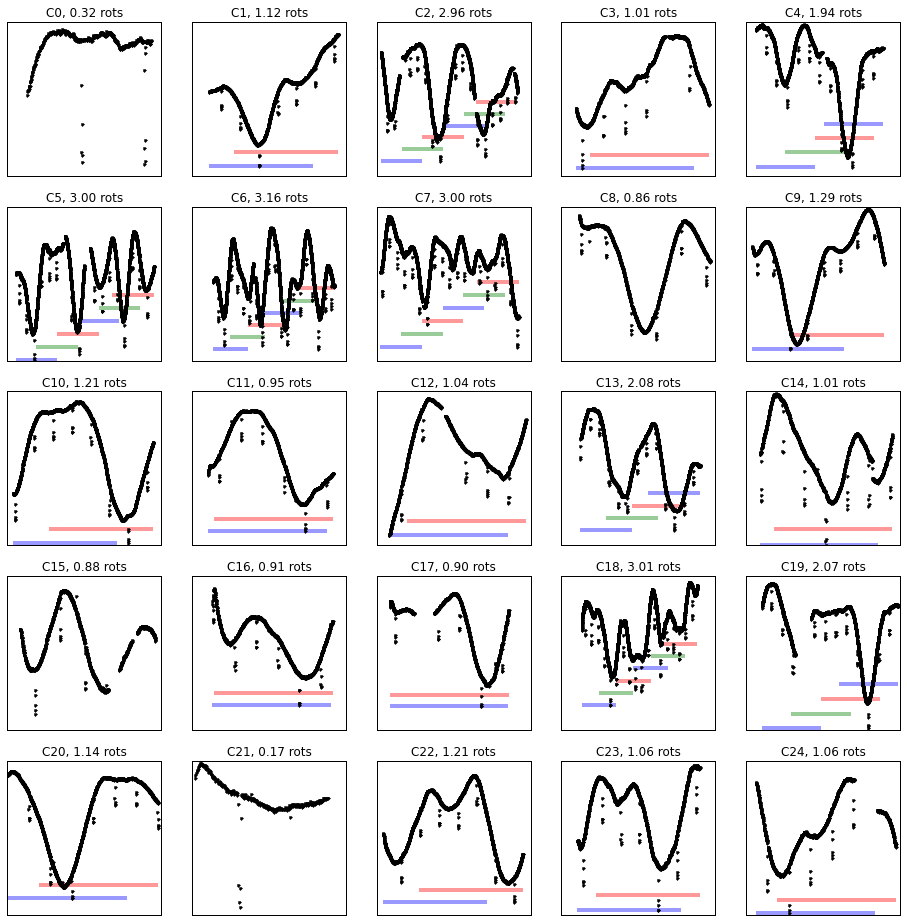

In [465]:
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(5, 5)
ax = [plt.subplot(gs_axis) for gs_axis in gs]

time_index_boundaries = np.concatenate([[0], sorted_gap_inds, [len(long_lc.times.jd)]])
rotation_fraction = 0.9
for i in range(len(time_index_boundaries) - 1):
    start, end = time_index_boundaries[i]+1, time_index_boundaries[i+1]
    times = long_lc.times.jd[sort_by_time][start:end]
    fluxes = long_lc.fluxes[sort_by_time][start:end]
        
    time_range = (times.max() - times.min())/rotation_period
    
    transit_model = generate_fiducial_model_lc_short(times,
                                                     2454605.89167, 0.00348, 
                                                     0.1029, 0.295)
    transits_in_chunk = (transit_model != 1).any()
    
    if 1 < (times.max() - times.min()) / (rotation_fraction*rotation_period) < 2:
        ax[i].hlines(xmin=times.min(),
                     xmax=times.min() + rotation_fraction*rotation_period, 
                     y=fluxes.min(), color='b', lw=4, alpha=0.4)

        ax[i].hlines(xmin=times.max() - rotation_fraction*rotation_period,
                     xmax=times.max(), 
                     y=fluxes.min() + (fluxes.max()-fluxes.min())/10, 
                     color='r', lw=4, alpha=0.4)
        
    elif (times.max() - times.min()) / (rotation_fraction*rotation_period) > 2:
        colorwheel = ['b', 'g', 'r']
        n_rotations = np.floor((times.max() - times.min()) / (rotation_fraction*rotation_period))
        for j in range(2*int(n_rotations) - 1):
            ax[i].hlines(fluxes.min() + j*(fluxes.max()-fluxes.min())/10, 
                         xmin=times.min() + j*0.5*rotation_fraction*rotation_period, 
                         xmax=times.min() + (j*0.5 + 1)*rotation_fraction*rotation_period,
                         color=colorwheel[j % len(colorwheel)], lw=4, alpha=0.4)
        ax[i].hlines(fluxes.min() + (j+1)*(fluxes.max()-fluxes.min())/10, 
             xmin=times.max() - rotation_fraction*rotation_period, 
             xmax=times.max(),
             color=colorwheel[(j+1) % len(colorwheel)], lw=4, alpha=0.4)
        
    ax[i].plot(times, fluxes, 'k.')
    ax[i].set(yticks=[], xticks=[], 
              title='C{0}, {1:.2f} rots'.format(i, time_range), 
              axis_bgcolor='w' if transits_in_chunk else 'gray')
plt.show()

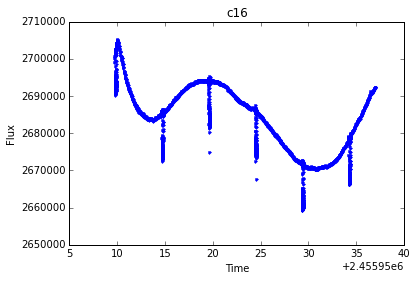

In [516]:
reload(datacleaner)
from datacleaner import combine_short_and_long_cadence, LightCurve

short_lc = LightCurve.from_dir(os.path.join('/astro/users/bmmorris/git/hat-11/lightcurves', 
                                            'transits_short'))

i = 16
start, end = time_index_boundaries[i]+1, time_index_boundaries[i+1]
start_jd, end_jd = long_lc.times.jd[sort_by_time][[start, end]]

short_inds_in_chunk = ((start_jd < short_lc.times.jd) *
                       (short_lc.times.jd < end_jd))

short_chunk = LightCurve(times=short_lc.times[short_inds_in_chunk], 
                         fluxes=short_lc.fluxes[short_inds_in_chunk],
                         errors=short_lc.errors[short_inds_in_chunk],
                         quarters=short_lc.quarters[short_inds_in_chunk])
short_transits = short_chunk8.get_transit_light_curves()

for transit in short_transits:
    transit.remove_linear_baseline()

long_chunk = LightCurve(times=long_lc.times[sort_by_time][start:end], 
                        fluxes=long_lc.fluxes[sort_by_time][start:end],
                        errors=long_lc.errors[sort_by_time][start:end],
                        quarters=long_lc.quarters[sort_by_time][start:end])

long_transits = LightCurve(name='transits_long', 
                           **long_chunk.mask_out_of_transit(oot_duration_fraction=1.5)
                          ).get_transit_light_curves()
    
stitched_chunk = combine_short_and_long_cadence(short_transits, long_transits, 
                                                long_chunk, name='c{0}'.format(i))

# Start with chunk 8
# start, end = time_index_boundaries[8]+1, time_index_boundaries[8+1]-20
# plt.plot(long_lc.times_jd[start:end], long_lc.fluxes[start:end], '.')
# plt.show()

stitched_chunk.plot(plot_kwargs={'color':'b', 'marker':'.', 'lw':0})

In [517]:
stitched_chunk.save_to('../lightcurves/', for_stsp=True, overwrite=True)

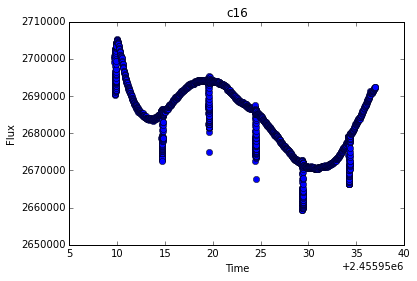

In [518]:
LightCurve.from_dir('../lightcurves/c16.txt', for_stsp=True).plot()

In [501]:
stitched_chunk.times.jd[0]

2455959.6463887556